# Лабораторная работа 2. Метод ближайших соседей и решающие деревья.

ФИО: Коваленко Павел Антонович

Группа: 317

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rc
%matplotlib inline

In [2]:
font = {'family': 'Verdana',
        'weight': 'normal',
        'size': 14}
rc('font', **font)
rc('legend', fontsize=14)

Все эксперименты в этой лабораторной работе предлагается проводить на данных соревнования Amazon Employee Access Challenge: https://www.kaggle.com/c/amazon-employee-access-challenge

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

Для удобства данные можно загрузить по ссылке: https://www.dropbox.com/s/q6fbs1vvhd5kvek/amazon.csv

Сразу прочитаем данные и создадим разбиение на обучение и контроль:

In [3]:
data = pd.read_csv('amazon.csv')
data.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [4]:
data.shape

(32769, 10)

In [5]:
# доля положительных примеров
data.ACTION.mean()

0.9421099209618847

In [6]:
# число значений у признаков
for col_name in data.columns:
    print(col_name, len(data[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [7]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)

## Часть 1: kNN и категориальные признаки

#### 1. Реализуйте три функции расстояния на категориальных признаках, которые обсуждались на втором семинаре. Реализуйте самостоятельно метод k ближайших соседей, который будет уметь работать с этими функциями расстояния. Подсчитайте для каждой из них качество на тестовой выборке `X_test` при числе соседей $k = 10$. Метрика качества — AUC-ROC.

Какая функция расстояния оказалась лучшей?

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
l = X_train.shape[0]
d = X_train.shape[1]

In [9]:
def my_knn_prob(X_train, y_train, X_test, k, dist):
    from scipy.stats import mode
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    n = 100
    labels = np.empty((0, k))
    for i in range(n):
        D = dist(X_test[X_test.shape[0] * i // n : X_test.shape[0] * (i + 1) // n], X_train)
        sr = np.arange(D.shape[0])[:, np.newaxis]
        pos = np.argpartition(D, k - 1, axis=1)[:, :k]
        pos = pos[sr, np.argsort(D[sr, pos])]
        lab = y_train[pos]
        labels = np.vstack((labels, lab))
    return labels.mean(axis=1)

$\rho(x_j, z_j) = [x_j \ne z_j]$

In [10]:
def dist1(X, Y):
    return (X[:, np.newaxis, :] != Y[np.newaxis, :, :]).sum(axis=2)

In [11]:
%%time
y_prob = my_knn_prob(X_train, y_train, X_test, 10, dist1)

Wall time: 36.2 s


In [12]:
roc_auc_score(y_test, y_prob)

0.829499015542142

$\rho(x_j, z_j) = [x_j \ne z_j] + [x_j = z_j] \sum\limits_{q: p_j(q) \leqslant p_j(x_j)} p_j^2(q)$

In [13]:
from collections import defaultdict
f = [defaultdict(float) for i in range(X_train.shape[1])]
for x in X_train.iterrows():
    for j in range(len(x[1])):
        f[j][int(x[1][j])] += 1

In [14]:
p2 = [defaultdict(float) for i in range(X_train.shape[1])]
for i in range(X_train.shape[1]):
    for j in f[i].keys():
        p2[i][j] = f[i][j] * (f[i][j] - 1) / l / (l - 1)

sp2 = [defaultdict(float) for i in range(X_train.shape[1])]
for i in range(X_train.shape[1]):
    for j in f[i].keys():
        for k in f[i].keys():
            if f[i][j] > f[i][k]:
                sp2[i][j] += p2[i][k]

In [15]:
def dist2(X, Y):
    xf = np.array([[sp2[i][x[i]] for i in range(len(x))] for x in X])
    return ((X[:, np.newaxis, :] != Y[np.newaxis, :, :]) + 
            (X[:, np.newaxis, :] == Y[np.newaxis, :, :]) * xf[:, np.newaxis, :]).sum(axis=2)

In [16]:
%%time
y_prob = my_knn_prob(X_train, y_train, X_test, 10, dist2)

Wall time: 2min 12s


In [17]:
roc_auc_score(y_test, y_prob)

0.83318947453169068

$\rho(x_j, z_j) = [x_j \ne z_j] ~ \log f_j(x_j) ~ \log f_j(z_j)$

In [18]:
from math import log
logf = [defaultdict(float) for i in range(X_train.shape[1])]
for i in range(X_train.shape[1]):
    for k in f[i].keys():
        logf[i][k] = log(f[i][k] + 1)

In [19]:
def dist3(X, Y):
    xf = np.array([[logf[i][x[i]] for i in range(len(x))] for x in X]) + 1
    yf = np.array([[logf[i][y[i]] for i in range(len(y))] for y in Y]) + 1
    return ((X[:, np.newaxis, :] != Y[np.newaxis, :, :]) * xf[:, np.newaxis, :] * yf[np.newaxis, :, :]).sum(axis=2)

In [20]:
%%time
y_prob = my_knn_prob(X_train, y_train, X_test, 10, dist3)

Wall time: 3min 23s


In [21]:
roc_auc_score(y_test, y_prob)

0.8241951994111224

#### 2 (бонус). Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какое наилучшее качество удалось достичь?

In [22]:
def my_knn_prob_magic(X_train, y_train, X_test, k, dist):
    from scipy.stats import mode
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    n = 100
    labels = np.empty((0, k[-1]))
    for i in range(n):
        D = dist(X_test[X_test.shape[0] * i // n : X_test.shape[0] * (i + 1) // n], X_train)
        sr = np.arange(D.shape[0])[:, np.newaxis]
        pos = np.argpartition(D, k - 1, axis=1)[:, :k[-1]]
        pos = pos[sr, np.argsort(D[sr, pos])]
        lab = y_train[pos]
        labels = np.vstack((labels, lab))
    return np.array([labels[:, :i].mean(axis=1) for i in k])

In [23]:
y_1 = my_knn_prob_magic(X_train, y_train, X_test, np.arange(1, 21), dist1)
y_2 = my_knn_prob_magic(X_train, y_train, X_test, np.arange(1, 21), dist2)
y_3 = my_knn_prob_magic(X_train, y_train, X_test, np.arange(1, 21), dist3)

In [24]:
score_1 = [roc_auc_score(y_test, y) for y in y_1]
score_2 = [roc_auc_score(y_test, y) for y in y_2]
score_3 = [roc_auc_score(y_test, y) for y in y_3]

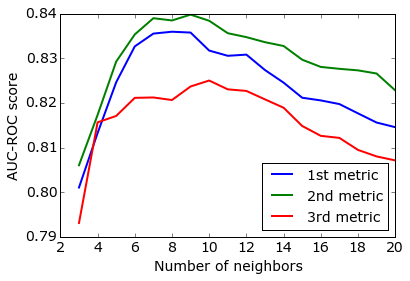

In [25]:
plt.plot(np.arange(3, 21), score_1[2:], label='1st metric', linewidth=2)
plt.plot(np.arange(3, 21), score_2[2:], label='2nd metric', linewidth=2)
plt.plot(np.arange(3, 21), score_3[2:], label='3rd metric', linewidth=2)
plt.xlabel('Number of neighbors')
plt.ylabel('AUC-ROC score')
plt.legend(loc='lower right')
plt.show()

In [26]:
print('1st metric: %d neighbors, %g score' % (np.argmax(score_1) + 1, np.max(score_1)))
print('2nd metric: %d neighbors, %g score' % (np.argmax(score_2) + 1, np.max(score_2)))
print('3rd metric: %d neighbors, %g score' % (np.argmax(score_3) + 1, np.max(score_3)))

1st metric: 8 neighbors, 0.835941 score
2nd metric: 9 neighbors, 0.839768 score
3rd metric: 10 neighbors, 0.825006 score


#### 3. Реализуйте счетчики (http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx), которые заменят категориальные признаки на вещественные.

А именно, каждый категориальный признак нужно заменить на три: 
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `clicks` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`clicks` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `clicks` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанный по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

#### Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

##### 1. С фолдингом

In [27]:
def dist_euc(X, Y):
    return (X ** 2).sum(axis=1)[:, np.newaxis] + (Y ** 2).sum(axis=1)[np.newaxis, :] - 2 * X.dot(Y.T) 

In [28]:
def knn_score_cv(X_train, y_train, k):
    y_train = np.array(y_train)
    from sklearn.cross_validation import KFold
    kf = KFold(X_train.shape[0], 3, random_state=42, shuffle=True)
    score = np.zeros(len(k))
    for i1, i2 in kf:
        y_pred = my_knn_prob_magic(X_train[i1], y_train[i1], X_train[i2], k, dist_euc)
        for i in range(len(k)):
            score[i] += roc_auc_score(y_train[i2], y_pred[i])
    return score / 3

In [29]:
counts = [[defaultdict(int) for j in range(d)] for i in range(3)]
clicks = [[defaultdict(int) for j in range(d)] for i in range(3)]
for i in range(l):
    x = X_train.irow(i)
    for j in range(d):
        counts[i * 3 // l][j][int(x[j])] += 1
        if y_train.irow(i):
            clicks[i * 3 // l][j][int(x[j])] += 1

In [30]:
X_train_c = np.zeros((l, d * 3))
for i in range(l):
    x = X_train.irow(i)
    for j in range(d):
        for k in range(3):
            if i * 3 // l != k:
                X_train_c[i][j * 3] += counts[k][j][x[j]]
                X_train_c[i][j * 3 + 1] += clicks[k][j][x[j]]
        X_train_c[i][j * 3 + 2] = (X_train_c[i][j * 3 + 1] + 1) / (X_train_c[i][j * 3] + 2)

In [32]:
X_test_c = np.zeros((X_test.shape[0], d * 3))
for i in range(X_test.shape[0]):
    x = X_test.irow(i)
    for j in range(d):
        for k in range(3):
            if i * 3 // l != k:
                X_test_c[i][j * 3] += counts[k][j][x[j]]
                X_test_c[i][j * 3 + 1] += clicks[k][j][x[j]]
        X_test_c[i][j * 3 + 2] = (X_test_c[i][j * 3 + 1] + 1) / (X_test_c[i][j * 3] + 2)

In [33]:
#y_cnt_1 = my_knn_prob_magic(X_train_c, y_train, X_test_c, np.arange(1, 31), dist_euc)

In [34]:
#score_cnt_1 = [roc_auc_score(y_test, y) for y in y_cnt_1]

In [35]:
score_cnt_1 = knn_score_cv(X_train_c, y_train, np.arange(1, 31))

In [36]:
print(score_cnt_1)

[ 0.63829578  0.66813076  0.68520431  0.70361765  0.71227587  0.717502
  0.72679547  0.72889915  0.73279077  0.73492921  0.73545095  0.73520703
  0.73367738  0.7335206   0.7340631   0.73567881  0.73411731  0.73536615
  0.73395377  0.73499862  0.7362823   0.73539317  0.73476004  0.73358301
  0.73561772  0.73676942  0.73721697  0.73640856  0.73615937  0.73427924]


In [37]:
print('Best score with folding: %g, on %d neighbors' % (score_cnt_1.max(), score_cnt_1.argmax() + 1))

Best score with folding: 0.737217, on 27 neighbors


##### 2. Без фолдинга

In [38]:
X_train_a = np.zeros((l, d * 3))
for i in range(l):
    x = X_train.irow(i)
    for j in range(d):
        for k in range(3):
            X_train_a[i][j * 3] += counts[k][j][x[j]]
            X_train_a[i][j * 3 + 1] += clicks[k][j][x[j]]
        X_train_a[i][j * 3 + 2] = (X_train_a[i][j * 3 + 1] + 1) / (X_train_a[i][j * 3] + 2)

In [39]:
X_test_a = np.zeros((X_test.shape[0], d * 3))
for i in range(X_test.shape[0]):
    x = X_test.irow(i)
    for j in range(d):
        for k in range(3):
            X_test_a[i][j * 3] += counts[k][j][x[j]]
            X_test_a[i][j * 3 + 1] += clicks[k][j][x[j]]
        X_test_a[i][j * 3 + 2] = (X_test_a[i][j * 3 + 1] + 1) / (X_test_a[i][j * 3] + 2)

In [40]:
#y_cnt_2 = my_knn_prob_magic(X_train_a, y_train, X_test_a, np.arange(1, 31), dist_euc)

In [41]:
#score_cnt_2 = [roc_auc_score(y_test, y) for y in y_cnt_2]

In [42]:
score_cnt_2 = knn_score_cv(X_train_a, y_train, np.arange(1, 31))

In [43]:
print(score_cnt_2)

[ 0.68670565  0.72062482  0.73709154  0.74514158  0.74998464  0.75375412
  0.75629325  0.75795765  0.7606288   0.76179034  0.7610539   0.76381604
  0.76291611  0.76338531  0.76290129  0.76142752  0.75861781  0.75889203
  0.7586034   0.75838067  0.7557911   0.75514159  0.75416603  0.75487566
  0.75709787  0.75698744  0.75531939  0.75441399  0.75220118  0.75050912]


In [44]:
print('Best score without folding: %g, on %d neighbors' % (score_cnt_2.max(), score_cnt_2.argmax() + 1))

Best score without folding: 0.763816, on 12 neighbors


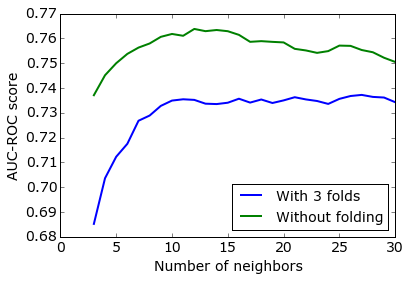

In [45]:
plt.plot(np.arange(3, 31), score_cnt_1[2:], label='With 3 folds', linewidth=2)
plt.plot(np.arange(3, 31), score_cnt_2[2:], label='Without folding', linewidth=2)
plt.xlabel('Number of neighbors')
plt.ylabel('AUC-ROC score')
plt.legend(loc='lower right')
plt.show()

#### 4. Добавьте в исходную выборку парные признаки — то есть для каждой пары $f_i$, $f_j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$. Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

##### 1. С фолдингом

In [47]:
cnts = [[[defaultdict(int) for i in range(j + 1)] for j in range(d)] for k in range(3)]
clcs = [[[defaultdict(int) for i in range(j + 1)] for j in range(d)] for k in range(3)]
for i in range(l):
    x = X_train.irow(i)
    for j in range(d):
        for k in range(j + 1):
            cnts[i * 3 // l][j][k][(x[j], x[k])] += 1
    if y_train.irow(i):
        for j in range(d):
            for k in range(j + 1):
                clcs[i * 3 // l][j][k][(x[j], x[k])] += 1

In [48]:
X_train_pair = np.zeros((l, d * (d + 1) // 2 * 3))
for i in range(l):
    x = X_train.irow(i)
    for j in range(d):
        for k in range(j + 1):
            idx = (j * (j + 1) // 2 + k) * 3
            for t in range(3):
                if i * 3 // l != t:
                    X_train_pair[i][idx] += cnts[t][j][k][(x[j], x[k])]
                    X_train_pair[i][idx + 1] += clcs[t][j][k][(x[j], x[k])]
            X_train_pair[i][idx + 2] = (X_train_pair[i][idx + 1] + 1) / (X_train_pair[i][idx] + 2)

In [49]:
X_test_pair = np.zeros((X_test.shape[0], d * (d + 1) // 2 * 3))
for i in range(X_test.shape[0]):
    x = X_test.irow(i)
    for j in range(d):
        for k in range(j + 1):
            idx = (j * (j + 1) // 2 + k) * 3
            for t in range(3):
                if i * 3 // l != t:
                    X_test_pair[i][idx] += cnts[t][j][k][(x[j], x[k])]
                    X_test_pair[i][idx + 1] += clcs[t][j][k][(x[j], x[k])]
            X_test_pair[i][idx + 2] = (X_test_pair[i][idx + 1] + 1) / (X_test_pair[i][idx] + 2)

In [50]:
#y_pair_1 = my_knn_prob_magic(X_train_pair, y_train, X_test_pair, np.arange(1, 31), dist_euc)

In [51]:
#score_pair_1 = [roc_auc_score(y_test, y) for y in y_pair_1]

In [52]:
score_pair_1 = knn_score_cv(X_train_pair, y_train, np.arange(1, 31))

In [53]:
print(score_pair_1)

[ 0.64798477  0.68989297  0.71095358  0.72313492  0.73143699  0.74079742
  0.74159752  0.74333266  0.74177262  0.7438286   0.7452195   0.74660098
  0.745729    0.74623969  0.74668984  0.7456597   0.74377241  0.74274368
  0.74229811  0.74391     0.74320374  0.74285696  0.74345527  0.74343323
  0.74293409  0.74150725  0.74234151  0.74195521  0.74167703  0.74066224]


In [54]:
print('Best score with folding and pair features: %g, on %d neighbors' % (score_pair_1.max(), score_pair_1.argmax() + 1))

Best score with folding and pair features: 0.74669, on 15 neighbors


##### 2. Без фолдинга

In [55]:
X_train_pair_2 = np.zeros((l, d * (d + 1) // 2 * 3))
for i in range(l):
    x = X_train.irow(i)
    for j in range(d):
        for k in range(j + 1):
            idx = (j * (j + 1) // 2 + k) * 3
            for t in range(3):
                X_train_pair_2[i][idx] += cnts[t][j][k][(x[j], x[k])]
                X_train_pair_2[i][idx + 1] += clcs[t][j][k][(x[j], x[k])]
            X_train_pair_2[i][idx + 2] = (X_train_pair_2[i][idx + 1] + 1) / (X_train_pair_2[i][idx] + 2)

In [56]:
X_test_pair_2 = np.zeros((X_test.shape[0], d * (d + 1) // 2 * 3))
for i in range(X_test.shape[0]):
    x = X_test.irow(i)
    for j in range(d):
        for k in range(j + 1):
            idx = (j * (j + 1) // 2 + k) * 3
            for t in range(3):
                X_test_pair_2[i][idx] += cnts[t][j][k][(x[j], x[k])]
                X_test_pair_2[i][idx + 1] += clcs[t][j][k][(x[j], x[k])]
            X_test_pair_2[i][idx + 2] = (X_test_pair_2[i][idx + 1] + 1) / (X_test_pair_2[i][idx] + 2)

In [57]:
#y_pair_2 = my_knn_prob_magic(X_train_pair_2, y_train, X_test_pair_2, np.arange(1, 31), dist_euc)

In [58]:
#score_pair_2 = [roc_auc_score(y_test, y) for y in y_pair_2]

In [59]:
score_pair_2 = knn_score_cv(X_train_pair_2, y_train, np.arange(1, 31))

In [60]:
print(score_pair_2)

[ 0.71073245  0.74177974  0.75703077  0.76363417  0.76541628  0.76752102
  0.76873262  0.77066017  0.77274004  0.77103818  0.7712682   0.77035744
  0.7698282   0.76913102  0.76754223  0.76529555  0.7653269   0.76540403
  0.76428026  0.76256797  0.76060129  0.75868129  0.75884484  0.75735227
  0.75721755  0.75573877  0.75647568  0.75458542  0.75347186  0.75225671]


In [61]:
print('Best score without folding and with pair features: %g, on %d neighbors' % 
      (score_pair_2.max(), score_pair_2.argmax() + 1))

Best score without folding and with pair features: 0.77274, on 9 neighbors


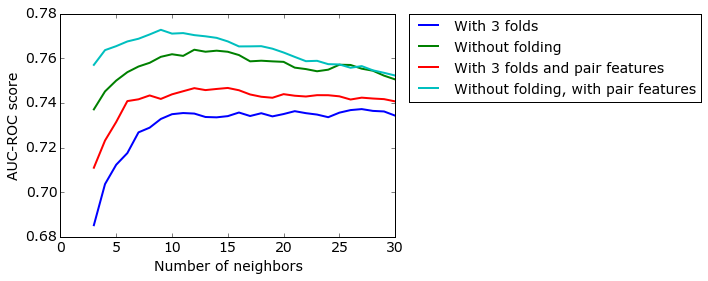

In [62]:
plt.plot(np.arange(3, 31), score_cnt_1[2:], label='With 3 folds', linewidth=2)
plt.plot(np.arange(3, 31), score_cnt_2[2:], label='Without folding', linewidth=2)
plt.plot(np.arange(3, 31), score_pair_1[2:], label='With 3 folds and pair features', linewidth=2)
plt.plot(np.arange(3, 31), score_pair_2[2:], label='Without folding, with pair features', linewidth=2)
plt.xlabel('Number of neighbors')
plt.ylabel('AUC-ROC score')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.031))
plt.show()

А теперь для лучших значений на кросс-валидации запустим каждый из четырех алгоритмов на тестовой выборке

In [63]:
y_1 = my_knn_prob(X_train_c, y_train, X_test_c, score_cnt_1.argmax() + 1, dist_euc)
y_2 = my_knn_prob(X_train_a, y_train, X_test_a, score_cnt_2.argmax() + 1, dist_euc)
y_3 = my_knn_prob(X_train_pair, y_train, X_test_pair, score_pair_1.argmax() + 1, dist_euc)
y_4 = my_knn_prob(X_train_pair_2, y_train, X_test_pair_2, score_pair_2.argmax() + 1, dist_euc)

In [73]:
print('AUC-ROC score for folded train data on test set: %g' % roc_auc_score(y_test, y_1))
print('AUC-ROC score for not folded train data on test set: %g' % roc_auc_score(y_test, y_2))
print('AUC-ROC score for folded train data with pair features on test set: %g' % roc_auc_score(y_test, y_3))
print('AUC-ROC score for not folded train data with pair features on test set: %g' % roc_auc_score(y_test, y_4))

AUC-ROC score for folded train data on test set: 0.758927
AUC-ROC score for not folded train data on test set: 0.791231
AUC-ROC score for folded train data with pair features on test set: 0.772111
AUC-ROC score for not folded train data with pair features on test set: 0.800937


Итого: в обоих случаях добавление парных фич улучшает качество как на кросс-валидации, так и на тестовой выборке. Однако и на тренировочной, и на тестовой выборке использование фолдинга при подсчете счетчиков ухудшает результат, что достаточно странно.

Помимо этого, для всех четырех случаев на тестовой выборке получено качество примерно на 0.03 лучше, чем на кросс-валидации, однако лучший все равно результат заметно уступает лучшему результату, полученному в предыдущем разделе с нестандартными метриками (0.8 против 0.84).

## Часть 2: Решающие деревья и леса

#### 1. Возьмите из предыдущей части выборку с парными признаками, преобразованную с помощью счетчиков без фолдинга. Настройте решающее дерево, подобрав оптимальные значения параметров `max_depth` и `min_samples_leaf`. Какой наилучший AUC-ROC на контроле удалось получить?

In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import KFold

In [75]:
q = np.zeros((10, 10))
y_tr_np = np.array(y_train)
for i in range(10):
    for j in range(10):
        kf = KFold(l, 3, random_state=42)
        for i1, i2 in kf:
            model = DecisionTreeClassifier(max_depth=20 * (i + 1), min_samples_leaf=(j + 1)).fit(X_train_pair_2[i1], y_tr_np[i1])
            y = model.predict_proba(X_train_pair_2[i2])
            q[i, j] += roc_auc_score(y_tr_np[i2], y[:, 1])
q /= 3

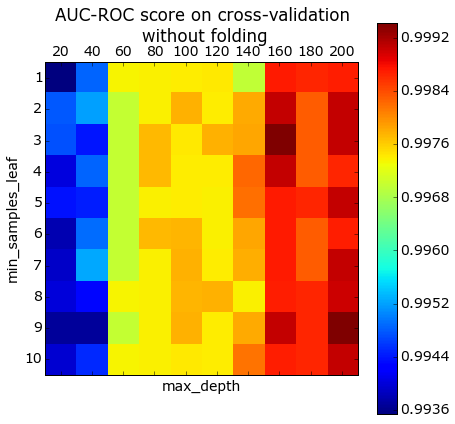

In [139]:
plt.matshow(q)
plt.gcf().set_size_inches(7, 7)
plt.colorbar()
plt.xlabel('max_depth')
plt.xticks(np.arange(10), np.arange(20, 201, 20))
plt.ylabel('min_samples_leaf')
plt.yticks(np.arange(10), np.arange(1, 11))
plt.title('AUC-ROC score on cross-validation\n without folding')
plt.show()

Вот это да. Думаю, по счетчикам, посчитанным на самой этой выборке, было несложно понять, где стоят единички. Ради интереса стоит построить дерево на данных, полученных с фолдингом.

In [77]:
t = np.zeros((10, 10))
y_tr_np = np.array(y_train)
for i in range(10):
    for j in range(10):
        kf = KFold(l, 3, random_state=42)
        for i1, i2 in kf:
            model = DecisionTreeClassifier(max_depth=20 * (i + 1), min_samples_leaf=(j + 1)).fit(X_train_pair[i1], y_tr_np[i1])
            y = model.predict_proba(X_train_pair[i2])
            t[i, j] += roc_auc_score(y_tr_np[i2], y[:, 1])
t /= 3

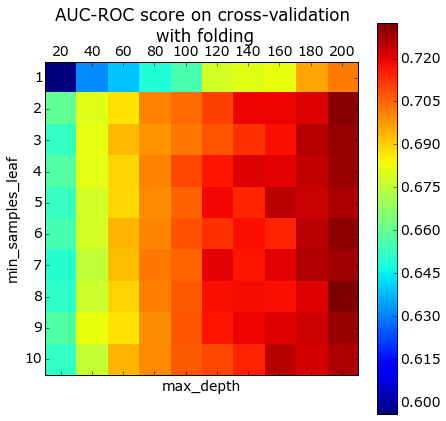

In [140]:
plt.matshow(t)
plt.gcf().set_size_inches(7, 7)
plt.colorbar()
plt.xticks(np.arange(10), np.arange(20, 201, 20))
plt.xlabel('max_depth')
plt.yticks(np.arange(10), np.arange(1, 11))
plt.ylabel('min_samples_leaf')
plt.title('AUC-ROC score on cross-validation\n with folding')
plt.show()

Судя по графикам, лучшее качество на кросс-валидации достигается без ограничения на высоту дерева и практически не зависит от минимального размера листа. Запустим оба алгоритма с лучшими параметрами на тестовой выборке.

In [135]:
model = DecisionTreeClassifier(min_samples_leaf=2).fit(X_train_pair_2, y_tr_np)
y_1 = model.predict_proba(X_test_pair_2)
sc_1 = roc_auc_score(y_test, y_1[:, 1])
print('AUC-ROC score for decision tree trained on non-folded data: %g' % sc_1)
model = DecisionTreeClassifier(min_samples_leaf=2).fit(X_train_pair, y_tr_np)
y_2 = model.predict_proba(X_test_pair)
sc_2 = roc_auc_score(y_test, y_2[:, 1])
print('AUC-ROC score for decision tree trained on folded data: %g' % sc_2)

AUC-ROC score for decision tree trained on non-folded data: 0.565035
AUC-ROC score for decision tree trained on folded data: 0.705001


Ага!!! Переобучилось! Этого и стоило ожидать. Однако качество даже с фолдами невысокое. С knn было сложно получить такой плохой результат.

#### 2. Настройте случайный лес, подобрав оптимальное число деревьев `n_estimators`. Какое качество на тестовой выборке он дает?

In [106]:
from sklearn.ensemble import RandomForestClassifier

In [131]:
qr = np.zeros(25)
kf = KFold(l, 3, random_state=42)
for i1, i2 in kf:
    model = RandomForestClassifier(n_estimators=0, warm_start=True, min_samples_leaf=2)
    for i in range(25):
        model.set_params(n_estimators=(model.n_estimators + 2)).fit(X_train_pair_2[i1], y_tr_np[i1])
        y = model.predict_proba(X_train_pair_2[i2])
        qr[i] += roc_auc_score(y_tr_np[i2], y[:, 1])
qr /= 3

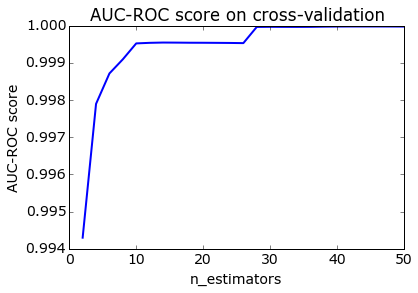

In [136]:
plt.plot(np.linspace(2, 50, 25), qr, linewidth=2)
plt.xlabel('n_estimators')
plt.ylabel('AUC-ROC score')
plt.title('AUC-ROC score on cross-validation')
plt.show()

In [143]:
model = RandomForestClassifier(n_estimators=0, min_samples_leaf=2, warm_start=True)
for i in [50, 100, 200, 500]:
    model.set_params(n_estimators=i).fit(X_train_pair_2, y_train)
    y_1 = model.predict_proba(X_test_pair_2)
    sc_1 = roc_auc_score(y_test, y_1[:, 1])
    print('AUC-ROC score on test set without folding for %d trees: %g' % (i, sc_1))

AUC-ROC score on test set without folding for 50 trees: 0.713437
AUC-ROC score on test set without folding for 100 trees: 0.709234
AUC-ROC score on test set without folding for 200 trees: 0.722591
AUC-ROC score on test set without folding for 500 trees: 0.720529


Уже лучше, чем одно дерево. Догнали одно дерево, обученное на данных с фолдингом.

#### 3. Возьмите выборку с парными признаками, для которой счетчики посчитаны с фолдингом. Обучите на ней случайный лес, подобрав число деревьев. Какое качество на тестовой выборке он дает? Чем вы можете объяснить изменение результата по сравнению с предыдущим пунктом?

In [133]:
qrf = np.zeros(25)
kff = KFold(l, 3, random_state=42)
for i1, i2 in kf:
    model = RandomForestClassifier(n_estimators=0, warm_start=True, min_samples_leaf=2)
    for i in range(25):
        model.set_params(n_estimators=(model.n_estimators + 2)).fit(X_train_pair[i1], y_tr_np[i1])
        y = model.predict_proba(X_train_pair[i2])
        qrf[i] += roc_auc_score(y_tr_np[i2], y[:, 1])
qrf /= 3

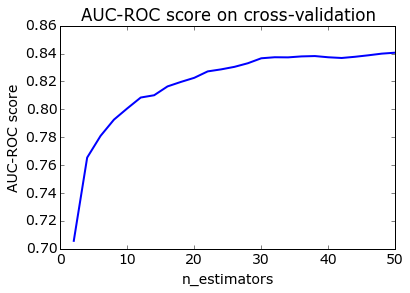

In [145]:
plt.plot(np.linspace(2, 50, 25), qrf, linewidth=2)
plt.xlabel('n_estimators')
plt.ylabel('AUC-ROC score')
plt.title('AUC-ROC score on cross-validation')
plt.show()

In [144]:
model = RandomForestClassifier(n_estimators=0, min_samples_leaf=2, warm_start=True)
for i in [50, 100, 200, 500]:
    model.set_params(n_estimators=i).fit(X_train_pair, y_train)
    y_1 = model.predict_proba(X_test_pair)
    sc_1 = roc_auc_score(y_test, y_1[:, 1])
    print('AUC-ROC score on test set with folding for %d trees: %g' % (i, sc_1))

AUC-ROC score on test set with folding for 50 trees: 0.856866
AUC-ROC score on test set with folding for 100 trees: 0.860816
AUC-ROC score on test set with folding for 200 trees: 0.863854
AUC-ROC score on test set with folding for 500 trees: 0.866366


Ну наконец-то обогнали KNN с хитрыми метриками! Кстати, качество лучше, чем на кросс-валидации.

Вы сами говорили где-то в начале, что вычислять счетчики на той же выборке, на которой потом будем по ним обучаться - плохая идея, которая наверняка приведет к переобучению. Так и получилось, видимо, дерево заметило, что если для всех 9 исходных признаков отношение кликов к счетчикам (заметно) отличается от 1, то это скорее всего представитель класса 0.